In [298]:
import yfinance as yf
from datetime import datetime, timedelta
from tqdm import tqdm

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# import tensorflow as tf
# from tensorflow import keras
# from keras import Sequential
# from keras.layers import SimpleRNN, LSTM, Dense

# from sklearn.tree import DecisionTreeRegressor
# from xgboost import XGBRegressor

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA

In [299]:
tickerSymbol = 'SI=F'
series = yf.Ticker(tickerSymbol)

prices = series.history(start='2024-01-01', end='2024-08-02').Open
returns = prices.pct_change().dropna()

prices_trading = prices['2024-06-29':]
returns_trading = prices_trading.pct_change().dropna()

Text(0, 0.5, 'Return')

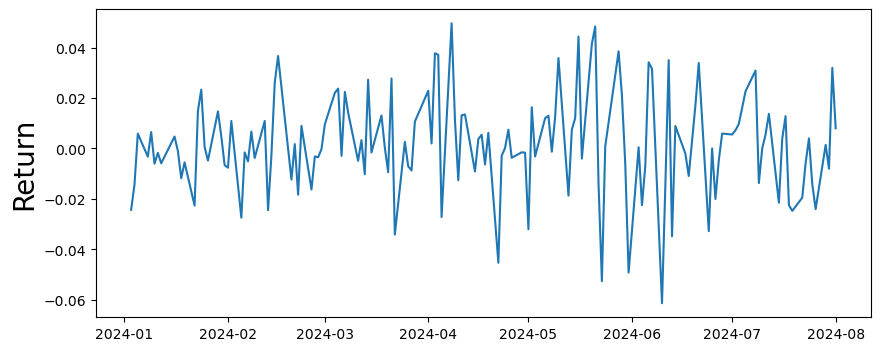

In [300]:
plt.figure(figsize=(10,4))
plt.plot(returns)
plt.ylabel('Return', fontsize=20)

In [301]:
print(returns)

Date
2024-01-03 00:00:00-05:00   -0.024324
2024-01-04 00:00:00-05:00   -0.014399
2024-01-05 00:00:00-05:00    0.005887
2024-01-08 00:00:00-05:00   -0.003252
2024-01-09 00:00:00-05:00    0.006525
                               ...   
2024-07-26 00:00:00-04:00   -0.024042
2024-07-29 00:00:00-04:00    0.001428
2024-07-30 00:00:00-04:00   -0.008021
2024-07-31 00:00:00-04:00    0.031986
2024-08-01 00:00:00-04:00    0.008010
Name: Open, Length: 146, dtype: float64


In [302]:
print(returns_trading)

Date
2024-07-02 00:00:00-04:00    0.007216
2024-07-03 00:00:00-04:00    0.009724
2024-07-05 00:00:00-04:00    0.022639
2024-07-08 00:00:00-04:00    0.030894
2024-07-09 00:00:00-04:00   -0.013718
2024-07-10 00:00:00-04:00   -0.000065
2024-07-11 00:00:00-04:00    0.005525
2024-07-12 00:00:00-04:00    0.013736
2024-07-15 00:00:00-04:00   -0.021521
2024-07-16 00:00:00-04:00    0.003910
2024-07-17 00:00:00-04:00    0.012821
2024-07-18 00:00:00-04:00   -0.022432
2024-07-19 00:00:00-04:00   -0.024750
2024-07-22 00:00:00-04:00   -0.019496
2024-07-23 00:00:00-04:00   -0.005828
2024-07-24 00:00:00-04:00    0.004000
2024-07-25 00:00:00-04:00   -0.014288
2024-07-26 00:00:00-04:00   -0.024042
2024-07-29 00:00:00-04:00    0.001428
2024-07-30 00:00:00-04:00   -0.008021
2024-07-31 00:00:00-04:00    0.031986
2024-08-01 00:00:00-04:00    0.008010
Name: Open, dtype: float64


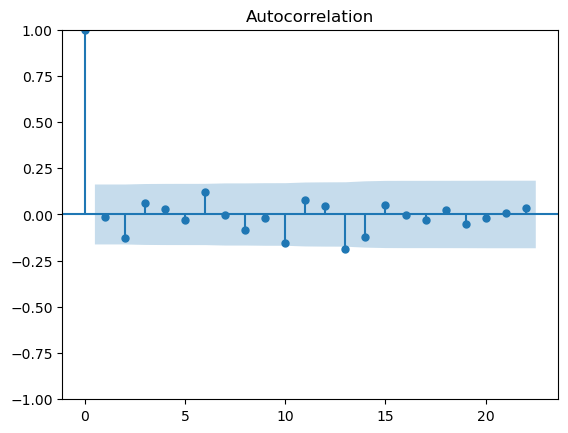

In [303]:
plot_acf(returns)
plt.show()

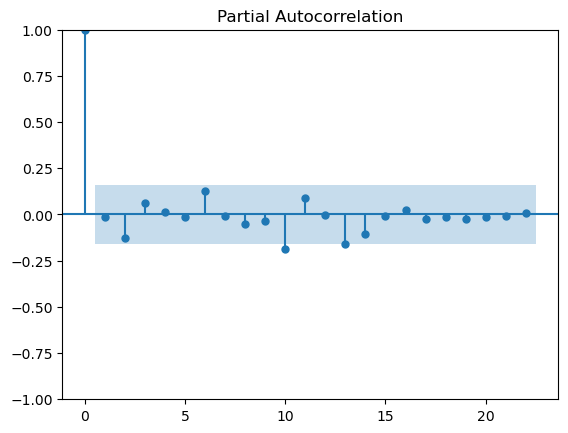

In [304]:
plot_pacf(returns)
plt.show()

In [305]:
# ARIMA
model = ARIMA(returns, order=(1,0,1))
results = model.fit()
prediction = results.forecast(1)

c:\Users\jessi\anaconda3\envs\use_this_env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\jessi\anaconda3\envs\use_this_env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\jessi\anaconda3\envs\use_this_env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\jessi\anaconda3\envs\use_this_env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an

In [306]:
print(results.forecast(1))

146    0.001342
dtype: float64


c:\Users\jessi\anaconda3\envs\use_this_env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


In [307]:
print(prediction)

146    0.001342
dtype: float64


In [308]:
baseline_profit = prices.iloc[-1] - prices.iloc[0]
baseline_profit = np.round(baseline_profit,2)
print("Baseline Profit:  $" + str(baseline_profit) + " per contract")

Baseline Profit:  $5.1 per contract


In [314]:
def BuySellModel(starting_cash, prices, returns, arima_order, window_size=10, thresh=0.01, verbose=False, plot=True):
    cash = starting_cash
    contracts = 0
    holding = False
    events_list = []

    init_amt = starting_cash

    for i in tqdm(range(window_size, len(prices)-1), total=len(prices)-window_size-1):
        window_returns = returns[i-window_size:i]
        date = prices.index[i]

        if holding:
            sell_price = prices.iloc[i]
            cash += sell_price * contracts
            contracts = 0
            holding = False
            ret = (sell_price - buy_price) / buy_price
            events_list.append(('s', date, ret))
            continue

        try:
            model = ARIMA(window_returns, order=arima_order)
            results = model.fit()
            pred = results.forecast()[0]

        except:
            pred = -np.inf

        if not holding and pred > thresh:
            buy_price = prices.iloc[i]
            contracts = int(cash / buy_price)
            cash -= buy_price * contracts
            holding = True
            events_list.append(('b', date))

    if holding:
        sell_price = prices.iloc[-1]
        cash += sell_price * contracts
        events_list.append(('s', prices.index[-1], (sell_price - buy_price) / buy_price))

    revenue = cash - starting_cash
    revenue_percent = (revenue * 100) / starting_cash
    baseline_revenue = prices.iloc[-1] * (starting_cash / prices.iloc[0]) - starting_cash

    if plot:
        plt.figure(figsize=(10, 4))
        plt.plot(prices)

        y_lims = (int(prices.min() * .95), int(prices.max() * 1.05))
        shaded_y_lims = int(prices.min() * .5), int(prices.max() * 1.5)

        for idx, event in enumerate(events_list):
            plt.axvline(event[1], color='k', linestyle='--', alpha=0.4)
            if event[0] == 's':
                color = 'green' if event[2] > 0 else 'red'
                plt.fill_betweenx(range(*shaded_y_lims),
                                  event[1], events_list[idx-1][1], color=color, alpha=0.1)

        tot_return = round(100 * (cash / init_amt - 1), 2)
        tot_return = str(tot_return) + '%'
        plt.title(f"Price Data\nThresh={thresh}\nTotal Amt: ${round(cash, 2)}\nTotal Return: {tot_return}", fontsize=20)
        plt.ylim(*y_lims)
        plt.show()

    return cash, revenue, revenue_percent, baseline_revenue

# Example usage:
# cash, revenue, revenue_percent, baseline_revenue = BuySellModel(10000, prices, returns, window_size=10, arima_order=(1,1,1), thresh=0.01, verbose=True, plot=True)


  0%|          | 0/136 [00:00<?, ?it/s]c:\Users\jessi\anaconda3\envs\use_this_env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\jessi\anaconda3\envs\use_this_env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\jessi\anaconda3\envs\use_this_env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\jessi\anaconda3\envs\use_this_env\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization fail

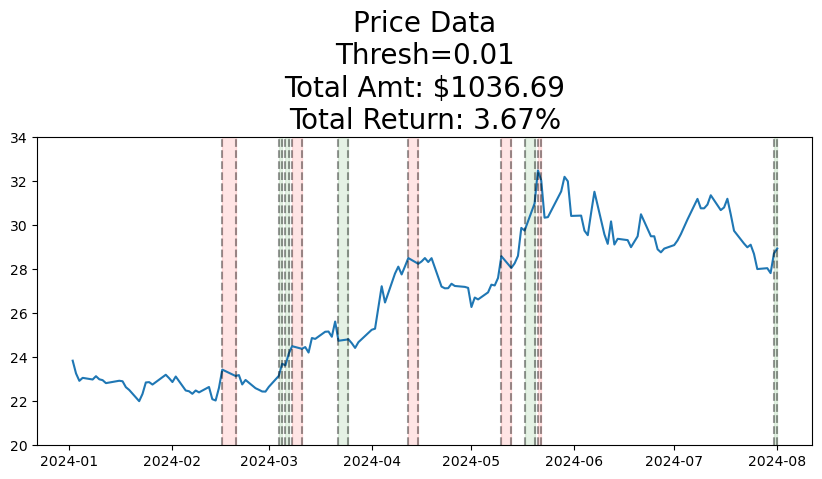

(1036.6870784759521, 36.68707847595215, 3.668707847595215, 213.88133899477407)

In [315]:
BuySellModel(starting_cash=1000, prices=prices, returns=returns, arima_order=(1,1,1), window_size=10, thresh=0.01)